### 1. Environment Settings

#### 1.1 Import Library

In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import argparse
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel, AutoTokenizer, AutoModel

#### 1.2 Setting Default Value

In [2]:
default_path = os.getcwd()
data_path = os.path.join(default_path, '../data')
base_model = os.path.join(default_path, '../base-model')
config_path = os.path.join(default_path, '../config')
log_path = os.path.join(default_path, '../log')
config_file = "bert-base.json"

#### 1.3 Load Dataset 

In [3]:
X_train = pd.read_csv(os.path.join(data_path, 'dsm_samp_train.csv'))
X_dev = pd.read_csv(os.path.join(data_path, 'dsm_samp_val.csv'))

#### 1.4 Load Pretrained model & tokenizer 

In [8]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [11]:
len(X_train), len(X_dev)

(63580, 15895)

In [12]:
X_train.label.unique()

array([9, 8, 6, 7, 2, 0, 1, 3, 5, 4], dtype=int64)

In [13]:
for i, name in label.items():
    print(name)

우울
무기력
급격한 체중(식욕)변화
수면장애
정서불안
피로
과도한 죄책감 및 무가치함
인지기능저하
자살충동
일상


In [16]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model, 'bert-tiny'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model, 'bert-tiny', 'bert_config.json'), num_labels=10)
model = BertForSequenceClassification.from_pretrained(os.path.join(base_model, 'bert-tiny'), config=config)

Some weights of the model checkpoint at F:\AuD\base-model\bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were no

#### 1.5 setting training args & config 

In [18]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [19]:
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [20]:
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 8, 'device': 'cpu', 'eval_batch_size': 8, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'warmup_proportion': 0, 'adam_epsilon': 1e-08, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100})

In [21]:
training_config.learning_rate

5e-05

In [22]:
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

### 2. Define Class

In [23]:
training_config.pad = 'max_length'
training_config.num_epochs  = 500

In [24]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [25]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sentence_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        pass
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [28]:
training_config.save_model_path = os.path.join(default_path, 'models')
training_config.log_path = os.path.join(default_path, 'log')

In [30]:
class BertTrainer():
    def __init__(self, config, training_config, model, train_dataloader, eval_dataloader, label_name, model_name):
        self.config = config
        self.training_config = training_config
        self.model = model
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.label_name = label_name
        self.model_name = model_name
        
    def set_seed(self):
        random.seed(self.training_config.seed)
        np.random.seed(self.training_config.seed)
        torch.manual_seed(self.training_config.seed)
        if not self.training_config.no_cuda and torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.training_config.seed)
    
    def train(self):
        train_acc_list = []; eval_acc_list = [] 
        train_loss_list = []; eval_loss_list = []
        # eval_acc_step = []; eval_loss_step = []
        # train_acc_step = []; train_loss_step = []
        nb_eval_steps = 0
        best_loss = 9999; best_epoch = 0
        t_total = len(self.train_dataloader) // self.training_config.gradient_accumulation_steps * self.training_config.num_epochs

        optimizer = AdamW(self.model.parameters(), lr=self.training_config.learning_rate, eps=self.training_config.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * self.training_config.warmup_proportion), \
                                                    num_training_steps=t_total)

        self.model.zero_grad()
        for epoch in range(int(self.training_config.num_epochs)):
            train_acc = 0.0; eval_acc = 0.0
            train_loss = 0.0; eval_loss = 0.0 

            for step, batch in enumerate(self.train_dataloader):
                self.model.train()
                batch = tuple(t.to(self.training_config.device) for t in batch)
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                criterion = nn.CrossEntropyLoss()
                # loss = outputs[0]
                # y_pred = torch.max(outputs[1], 1)[1]
                y_pred = outputs[1]
                y_true = batch[3]
                # y_true = torch.tensor([float(t) for t in y_true]).to(self.training_config.device)
                loss = criterion(y_pred, y_true)
                # print(outputs[0], outputs[1], batch[3])
                loss.backward()
                train_loss += loss.item()
                train_acc += self.calc_accuracy(outputs[1], batch[3])

                optimizer.step()
                scheduler.step()
                self.model.zero_grad()
                '''
                if step % training_config.logging_steps == 0:
                    # print(f'step: {step}, {train_acc / (step + 1)}')
                    # print(f'step: {step}, {train_loss / (step + 1)}')
                    train_acc_step.append([step, train_acc / (step + 1)])
                    train_loss_step.append([step, train_loss / (step + 1)])'''

            train_acc = train_acc / (step + 1)
            train_loss = train_loss / (step + 1)
            print(f'epoch: {epoch}, train_loss: {train_loss}')
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)

            for step2, batch2 in enumerate(self.eval_dataloader):
                self.model.eval()
                batch2 = tuple(t.to(self.training_config.device) for t in batch2)

                with torch.no_grad():
                    inputs = {
                        "input_ids": batch2[0],
                        "attention_mask": batch2[1],
                        "token_type_ids": batch2[2],
                        "labels": batch2[3]
                    }
                    outputs = self.model(**inputs)
                    tmp_eval_loss, logits = outputs[:2]
                    loss2 = criterion(logits, batch2[3])
                    eval_loss += loss2.item()              
                    # eval_loss += tmp_eval_loss.mean().item()
                    eval_acc += self.calc_accuracy(outputs[1], batch2[3]) 
                    '''
                    if step2 % training_config.logging_steps == 0:
                        eval_acc_step.append([step2, eval_acc / (step + 1)])
                        eval_loss_step.append([step2, eval_loss / (step + 1)])'''
            '''            
            try:
                last_loss = eval_loss_list[-1]
            except:
                last_loss = 9999
            '''
            eval_loss = eval_loss / (step2 + 1)
            eval_acc = eval_acc / (step2 + 1)
            eval_acc_list.append(eval_acc)
            eval_loss_list.append(eval_loss)
            print(f'epoch: {epoch}, eval_loss: {eval_loss}')
            
            if eval_loss < best_loss:
                best_loss = eval_loss
                es = 0
                print(f'save best loss state model & log(epoch {epoch + 1})')
                self.save_model(os.path.join(self.training_config.save_model_path, self.label_name, self.model_name, f'bert_dsm_{epoch}.pt'))
                best_epoch = epoch
            else:
                es += 1
                print("Counter {} of 5".format(es))

            if es > 4:
                print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", eval_loss, "...")
                break
                
            '''
            if eval_loss > last_loss:
                trigger_times += 1
                print('Trigger Times:', trigger_times)
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_{epoch}.pt'))
                
                if trigger_times > 4:
                    print("Early stopping !")
                    self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_best.pt'))
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0'''
            

        self.save_log(train_acc_list, train_loss_list, eval_acc_list, eval_loss_list, epoch)
        return train_acc_list, train_loss_list, eval_acc_list, eval_loss_list

    def calc_accuracy(self, X,Y):
        max_vals, max_indices = torch.max(X, 1)
        train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
        return train_acc
    
    def compute_metrics(self, labels, preds):
        assert len(preds) == len(labels)
        acc = (labels == preds).mean()
        return {"acc": acc}
    
    def save_log(self, train_acc, train_loss, eval_acc, eval_loss, epoch):
        with open(os.path.join(self.training_config.log_path, self.label_name, self.model_name, f'train_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(train_acc, f, pickle.HIGHEST_PROTOCOL)
        
        with open(os.path.join(self.training_config.log_path, self.label_name, self.model_name, f'train_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(train_loss, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.log_path, self.label_name, self.model_name, f'eval_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(eval_acc, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.log_path, self.label_name, self.model_name, f'eval_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(eval_loss, f, pickle.HIGHEST_PROTOCOL)  
    
    def save_model(self, model_name):
        torch.save(self.model.state_dict(), model_name)

### 3. Model Train

In [31]:
label_name = 'label_10'
model_name = 'bert-tiny'

In [32]:
len(X_train.label.unique())

10

In [33]:
train_file = BertDataset(X_train)
val_file = BertDataset(X_dev)

In [34]:
len(train_file), len(val_file)

(63580, 15895)

In [35]:
config.max_position_embeddings = 128
config.max_position_embeddings

128

In [36]:
bert_processor = BertProcessor(config, training_config, tokenizer)

In [38]:
train_dataset = bert_processor.convert_data(train_file)
val_dataset = bert_processor.convert_data(val_file)

In [39]:
train_sampler = bert_processor.shuffle_data(train_dataset, 'train')
val_sampler = bert_processor.shuffle_data(val_dataset, 'eval')

In [40]:
train_dataloader = bert_processor.load_data(train_dataset, train_sampler)
val_dataloader = bert_processor.load_data(val_dataset, val_sampler)

In [41]:
len(train_dataloader), len(val_dataloader)

(7948, 1987)

In [42]:
bert_trainer = BertTrainer(config, training_config, model, train_dataloader, val_dataloader, label_name, model_name)

In [ ]:
train_acc, train_loss, eval_acc, eval_loss = bert_trainer.train()

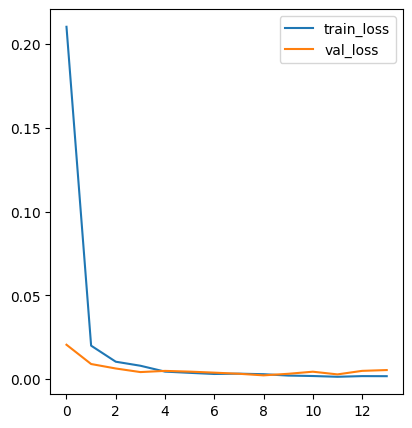

In [471]:
num_epochs = list(range(len(train_loss)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
plt.plot(list(range(len(train_loss))), eval_loss, label='val_loss')

plt.legend()
plt.show()